In [6]:
%pip install pylatex pandas matplotlib numpy tikzplotlib pdflatex

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd

df = pd.read_csv("measurements/new-new-reliable-results.csv")
df

,content_type,number_of_peers,opt_type,runtime_in_ms,success,objective,max_delay
0,AUDIO,2,DIR,0.1566,1,126.0,66.6596
1,AUDIO,2,HEU,2.4209,1,126.0,66.6596
2,AUDIO,2,ILP,1057.6732,1,126.0,66.6596
3,AUDIO,2,MST,12.0234,1,126.0,66.6596
4,AUDIO,8,DIR,0.0179,1,513.0,69.8958
...,...,...,...,...,...,...,...
142,AUDIO,37,HEU,102.2868,1,780.0,98.1052
143,AUDIO,37,MST,21.8549,0,0.0,100.0000
144,AUDIO,43,DIR,0.0963,1,3454.0,81.8154
145,AUDIO,43,HEU,79.1059,1,902.0,99.2192


In [8]:
MAX_PEERS = 40

opt_data_by_content = {}

# Gather data for plotting
for content_type in df["content_type"].unique():
    if content_type != "AUDIO":
        continue
    data = df[(df["content_type"] == content_type) & (df["number_of_peers"] <= MAX_PEERS) & (df["objective"] > 0)].sort_values(["number_of_peers"])
    print(f"Content type: {content_type}:\n{data.describe()}")

    peers = data["number_of_peers"].unique()
    dir_data = data[data["opt_type"] == "DIR"]
    heu_data = data[data["opt_type"] == "HEU"]
    ilp_data = data[data["opt_type"] == "ILP"]
    mst_data = data[data["opt_type"] == "MST"]

    # Adjust zero values in dir_data to 0.1 to avoid log(0)
    dir_data.loc[dir_data["runtime_in_ms"] <= 0.1, "runtime_in_ms"] = 0.1

    # Put data together for plotting
    opt_data = {"DIR": dir_data, "HEU": heu_data, "ILP": ilp_data, "MST": mst_data}
    opt_data_by_content[content_type] = opt_data

print("Data for plotting:")
for content_type, opt_data in opt_data_by_content.items():
    print(content_type)
    for opt_type, data in opt_data.items():
        print(f"\t{opt_type}: #{len(data)}")

Content type: AUDIO:
       number_of_peers  runtime_in_ms  success    objective  max_delay
count        99.000000   9.900000e+01     99.0    99.000000  99.000000
mean         18.000000   9.621703e+04      1.0   898.050505  83.225824
std          11.695106   4.717501e+05      0.0   869.038706  11.385412
min           2.000000   1.790000e-02      1.0   126.000000  66.659600
25%           8.000000   4.915000e-02      1.0   257.000000  73.977600
50%          16.000000   1.107380e+01      1.0   647.000000  81.815400
75%          28.000000   3.882385e+01      1.0  1275.000000  96.891350
max          40.000000   3.400790e+06      1.0  3319.000000  99.219200
Data for plotting:
AUDIO
	DIR: #39
	HEU: #39
	ILP: #12
	MST: #9


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("pgf")
# plt.rcParams.update({
#     "svg.fonttype": "none",
#     "pgf.texsystem": "pdflatex",
#     "text.usetex": True,
#     "pgf.rcfonts": False,
# })

from matplotlib.gridspec import GridSpec

NAMES = {
    "DIR": "No Media Routing",
    "HEU": "Heuristic Media Routing",
    "ILP": "ILP",
    "MST": "MST",
}

LATENCIES = {
    # "VIDEO": 400,
    "AUDIO": 100,
    # "MESSAGING": 1000,
    # "GAMING": 75,
}

def plot_runtime_vs_peers(opt_data_by_content, time_exceeded: float | None = None, delay_exceeded: float | None = None):
    COLORED_MARKERS = [("black", "o"), ("blue", "p"), ("red", "s"), ("green", "^")]
    fontdict = {"fontsize": 24}
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20

    col_count = 3
    row_count = (len(opt_data_by_content) + col_count - 1) // col_count

    # Create the figure and grid specification
    fig = plt.figure(figsize=(6.75 * col_count, 3 * 5.45 * row_count))
    gs = GridSpec(3 * row_count, col_count, width_ratios=[1] * col_count, figure=fig, wspace=0.25, hspace=0.125)

    for i, (content_type, opt_data) in enumerate(sorted(opt_data_by_content.items(), key=lambda x: LATENCIES[x[0]], reverse=True)):
        peers = range(2, MAX_PEERS + 1)

        # Logarithmic scale subplot
        ax = fig.add_subplot(gs[i, 0])
        # ax.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax.set_yscale("log")
        ax.set_xlabel("# peers", fontdict=fontdict, labelpad=2.25)
        if i == 0:
            ax.set_ylabel("Runtime [ms]", fontdict=fontdict, labelpad=2.25)
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax.set_ylim([0.1, 1e7])
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x) if int(x) % 2 == 0 else ""))

        # Linear scale subplot for the objective value
        ax2 = fig.add_subplot(gs[i, 1])
        # ax2.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax2.set_yscale("linear")
        ax2.set_xlabel("# peers", fontdict=fontdict, labelpad=2.25)
        if i == 0:
            ax2.set_ylabel("Cost [unit]", fontdict=fontdict, labelpad=2.25)
        ax2.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax2.set_ylim([0, 3500])
        # write 1000 as 1k
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}k" if x >= 1000 else str(int(x))))
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x) if int(x) % 2 == 0 else ""))

        # Linear scale subplot for the delay value
        ax3 = fig.add_subplot(gs[i, 2])
        # ax3.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax3.set_yscale("linear")
        ax3.set_xlabel("# peers", fontdict=fontdict, labelpad=2.25)
        if i == 0:
            ax3.set_ylabel("Max E2E delay [ms]", fontdict=fontdict, labelpad=2.25)
        ax3.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax3.set_ylim([50, LATENCIES[content_type] + 8])
        # only print numbers for every 2nd tick
        ax3.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
        ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x) if int(x) % 2 == 0 else ""))

        for (opt, data), (color, marker) in zip(opt_data.items(), COLORED_MARKERS):
            opt_name = NAMES[opt]
            count = min(len(data), len(peers))
            ax.plot(peers[:count], data["runtime_in_ms"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax2.plot(peers[:count], data["objective"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax3.plot(peers[:count], data["max_delay"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)

    ax.axhline(y=2*3600*1000, color="black", linestyle="--", linewidth=0.8)
    ax.text(33.25, 3.6e6, "2 hours", color="black", fontsize=16, verticalalignment="center")
    if time_exceeded is not None:
        ax.axvline(x=time_exceeded, color="black", linestyle="--", linewidth=0.8)
        ax.text(time_exceeded + .25, .6e6, "ILP\nexceeds\ntime\nlimit", color="red", fontsize=16, verticalalignment="center")
    delay_bound = LATENCIES[content_type]
    ax3.axhline(y=delay_bound, color="black", linestyle="--", linewidth=0.8)
    ax3.text(33.5, delay_bound + 4.5, f"{delay_bound} ms", color="black", fontsize=16, verticalalignment="center")
    if delay_exceeded is not None:
        ax3.axvline(x=delay_exceeded, color="black", linestyle="--", linewidth=0.8)
        ax3.text(delay_exceeded + .25, 35 + 20.5, "MST\nexceeds\ndelay\nbound", color="green", fontsize=16, verticalalignment="center")

    # Labels from the last subplot
    handles, labels = ax.get_legend_handles_labels()
    # set minimal padding for the legend
    fig.legend(handles, labels, ncol=len(labels), loc="upper center", bbox_to_anchor=(0.5, 0.915), borderaxespad=0.01, fontsize=20)

    # Show the plot
    plt.savefig("runtime_vs_peers.png", bbox_inches="tight", pad_inches=0)
    # plt.savefig("runtime_vs_peers.svg", bbox_inches="tight", pad_inches=0.1)
    # plt.savefig("runtime_vs_peers.pgf", bbox_inches="tight", pad_inches=0.1)


Time exceeded: 14
Delay exceeded: 11


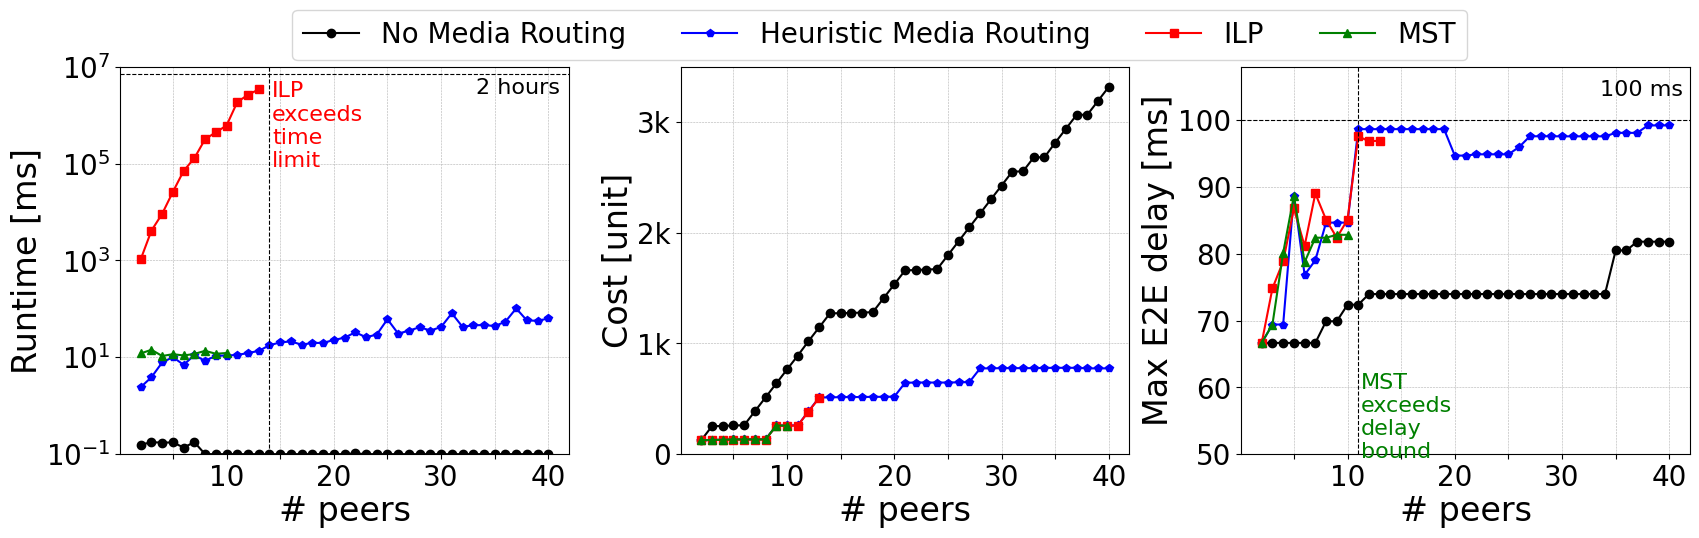

In [70]:
time_exceeded = df[(df["content_type"] == "AUDIO")].groupby("opt_type").agg("number_of_peers").max()["ILP"] + 1
print(f"Time exceeded: {time_exceeded}")

delay_exceeded = df[(df["content_type"] == "AUDIO") & (df["number_of_peers"] <= MAX_PEERS) & (df["objective"] == 0)].sort_values(["number_of_peers"]).head(1)
if len(delay_exceeded) > 0:
    delay_exceeded = delay_exceeded["number_of_peers"].values[0]
    print(f"Delay exceeded: {delay_exceeded}")

plot_runtime_vs_peers(opt_data_by_content, time_exceeded=time_exceeded, delay_exceeded=delay_exceeded)